## Цель проекта

Представлены исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 1. Подготовка

In [120]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [121]:
df = df.sort_index(axis = 0) 
print(df.index.is_monotonic)

True


In [122]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()

In [123]:
df2 = df

# 2. Анализ

In [124]:
df2 = df.reset_index(drop = False)
df2['weekday'] = df2['datetime'].dt.weekday

In [125]:
df3 = df

In [126]:
df3 = df3.reset_index(drop = False)

In [127]:
df3['weekday'] = df2['weekday']

In [128]:
df3 = df3.set_index('datetime')
df3

,num_orders,weekday
datetime,,
2018-03-01 00:00:00,124,3
2018-03-01 01:00:00,85,3
2018-03-01 02:00:00,71,3
2018-03-01 03:00:00,66,3
2018-03-01 04:00:00,43,3
...,...,...
2018-08-31 19:00:00,136,4
2018-08-31 20:00:00,154,4
2018-08-31 21:00:00,159,4


По всей видимости распределение по дням недели относительно равномерно.)

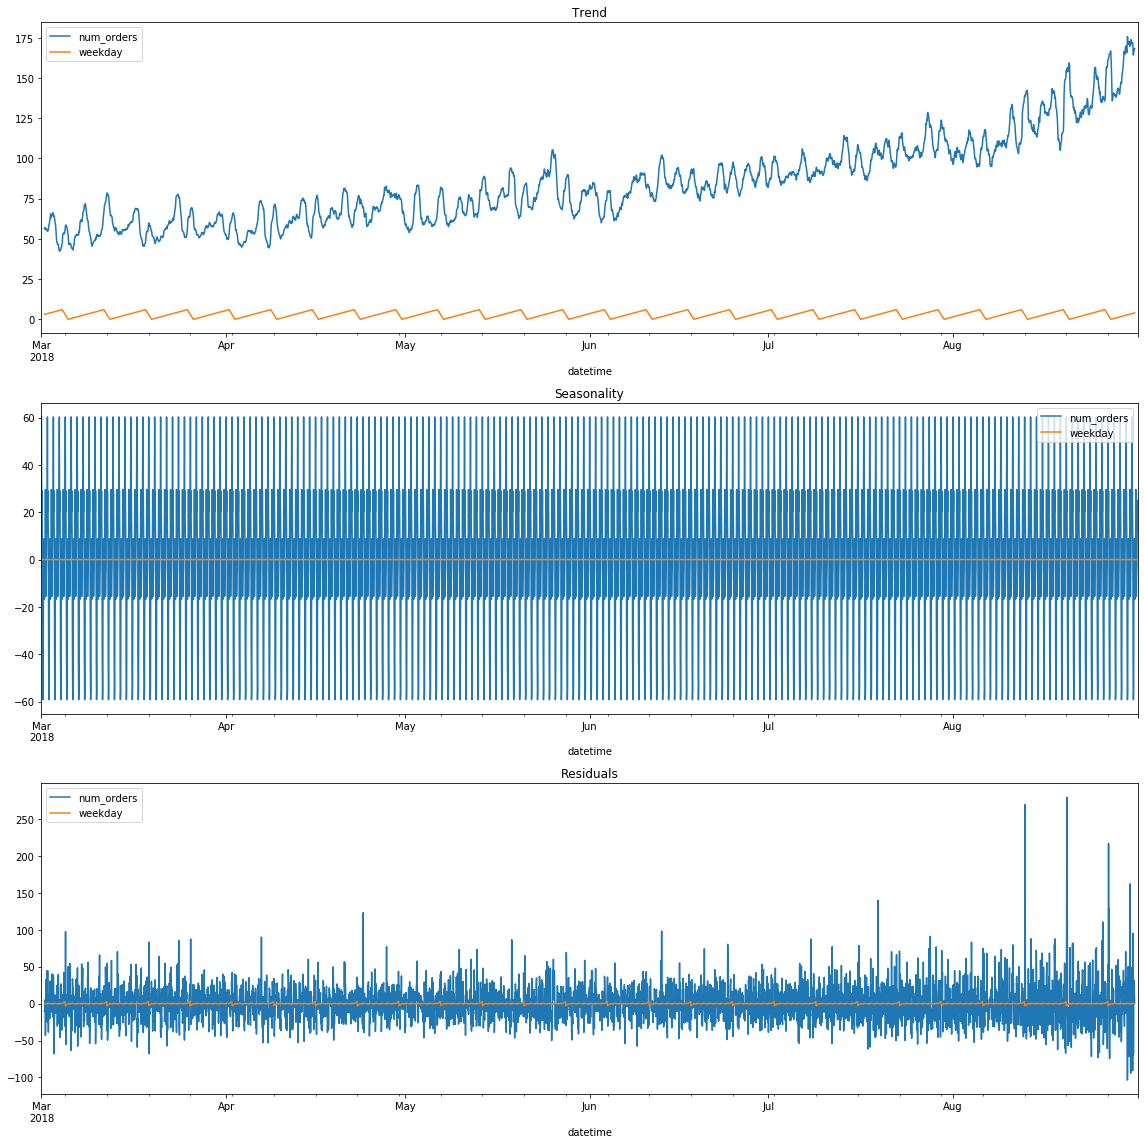

In [129]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(df3)
plt.figure(figsize=(16, 16))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Прослеживается тренд - чем ближе "сезон отпусков", тем большей популярностью пользуются услуги такси. "Бархатный сезон" демонстрирует резкий рост количество заказов такси.

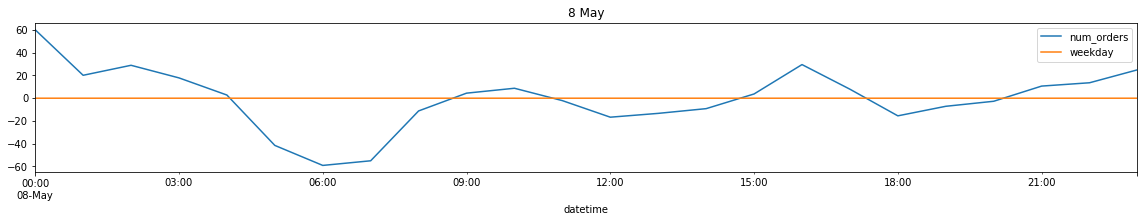

In [130]:
plt.figure(figsize=(16, 8))
plt.subplot(312)
decomposed.seasonal['2018-05-08':'2018-05-08'].plot(ax=plt.gca())
plt.title('8 May')
plt.tight_layout()

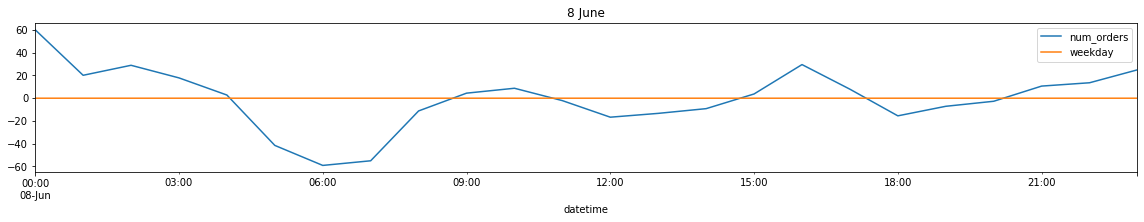

In [131]:
plt.figure(figsize=(16, 8))
plt.subplot(312)
decomposed.seasonal['2018-06-08':'2018-06-08'].plot(ax=plt.gca())
plt.title('8 June')
plt.tight_layout()

Цикличность в рамках датасета прослеживается - суточная.

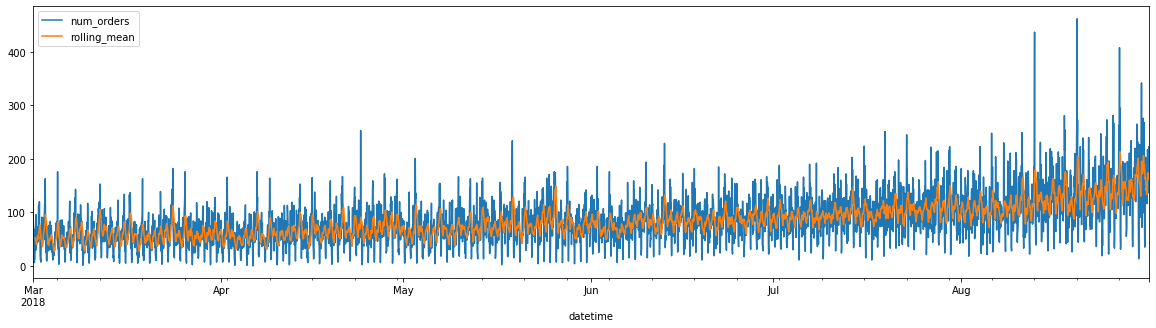

In [132]:
df['rolling_mean'] = df.rolling(10).mean()
df1 = df.query('num_orders != "nan"')
df1.plot(figsize=(20,5))

# 3. Обучение

In [133]:
def make_features(df, max_lag, rolling_mean_size):
    df['hour'] = df.index.hour


    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(df3, 8, 3)

learn, test = train_test_split(df3, shuffle=False, test_size=0.2)
train, valid = train_test_split(learn, shuffle=False, test_size=0.2)
train = train.dropna()

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

In [134]:
model = LinearRegression()
model.fit(features_train, target_train)
pred_train = model.predict(features_train)
mse = mean_squared_error(target_train, pred_train)
RMSE = mse ** 0.5
print("RMSE:", RMSE)

RMSE: 28.04388031640115


In [135]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(random_state=12345, max_depth=3)
model.fit(features_train, target_train)
pred_train = model.predict(features_train)
mse = mean_squared_error(target_train, pred_train)
RMSE = mse ** 0.5
print("RMSE:", RMSE)

RMSE: 24.9948510940133


In [136]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=12345, n_estimators=8, max_depth=8)
model.fit(features_train, target_train)
pred_train = model.predict(features_train)
mse = mean_squared_error(target_train, pred_train)
RMSE = mse ** 0.5
print("RMSE:", RMSE)

RMSE: 17.927823988956696


In [137]:
for estim in range(50, 100, 2):
    model = RandomForestRegressor(n_estimators=estim, random_state=12345, max_depth=100)
    model.fit(features_train, target_train)
    pred_train = model.predict(features_train)
    pred_valid = model.predict(features_valid)
    pred_test = model.predict(features_test)
    mse_train = mean_squared_error(target_train, pred_train)
    mse_valid = mean_squared_error(target_valid, pred_valid)
    mse_test = mean_squared_error(target_test, pred_test)
    rmse_train = mse_train ** 0.5
    rmse_valid = mse_valid ** 0.5
    rmse_test = mse_test ** 0.5
    print("n_estimators =", estim)
    print("rmse_train = ", rmse_train)
    print("rmse_valid = ", rmse_valid)
    print("rmse_test = ", rmse_test)

n_estimators = 50
rmse_train =  8.01654305697347
rmse_valid =  27.3990126707586
rmse_test =  50.61123697505127
n_estimators = 52
rmse_train =  8.016265713023284
rmse_valid =  27.374087589756474
rmse_test =  50.42217912441464
n_estimators = 54
rmse_train =  8.030294579770601
rmse_valid =  27.41864411877646
rmse_test =  50.47823477827223
n_estimators = 56
rmse_train =  7.978016066673158
rmse_valid =  27.377776995461176
rmse_test =  50.35107713912702
n_estimators = 58
rmse_train =  7.951207400931201
rmse_valid =  27.387070619230684
rmse_test =  50.398467249380055
n_estimators = 60
rmse_train =  7.934865778306106
rmse_valid =  27.409759501319297
rmse_test =  50.58474757677191
n_estimators = 62
rmse_train =  7.931264304126083
rmse_valid =  27.38151478301795
rmse_test =  50.57425472388167
n_estimators = 64
rmse_train =  7.911708192937261
rmse_valid =  27.3923649024475
rmse_test =  50.45916811797681
n_estimators = 66
rmse_train =  7.917972821320686
rmse_valid =  27.403871482278227
rmse_test =

### CatBoostRegressor

In [138]:
from catboost import CatBoostRegressor

for n in range(1,6,1):

    modelCatBoost = CatBoostRegressor(loss_function="RMSE", iterations=30, learning_rate = 1,
                                  max_depth=n)
    modelCatBoost = modelCatBoost.fit(features_train, target_train)
    
    train_modelCatBoost_predictions = modelCatBoost.predict(features_train)   
    valid_modelCatBoost_predictions = modelCatBoost.predict(features_valid)    
    test_modelCatBoost_predictions = modelCatBoost.predict(features_test)
    print('max_depth :', n)
    print("RMSE train:", (mean_squared_error(target_train, train_modelCatBoost_predictions))** 0.5)
    print("RMSE valid:", (mean_squared_error(target_valid, valid_modelCatBoost_predictions))** 0.5)
    print("RMSE test:", (mean_squared_error(target_test, test_modelCatBoost_predictions))** 0.5)

0:	learn: 30.3591148	total: 833us	remaining: 24.2ms
1:	learn: 28.7779619	total: 1.76ms	remaining: 24.6ms
2:	learn: 28.1226638	total: 2.39ms	remaining: 21.5ms
3:	learn: 27.3226085	total: 3.09ms	remaining: 20.1ms
4:	learn: 26.7343409	total: 3.74ms	remaining: 18.7ms
5:	learn: 26.3334808	total: 4.37ms	remaining: 17.5ms
6:	learn: 25.7980321	total: 5.02ms	remaining: 16.5ms
7:	learn: 25.5162123	total: 5.64ms	remaining: 15.5ms
8:	learn: 25.1182489	total: 6.31ms	remaining: 14.7ms
9:	learn: 24.9148695	total: 6.93ms	remaining: 13.9ms
10:	learn: 24.6109750	total: 7.51ms	remaining: 13ms
11:	learn: 24.2816626	total: 8.13ms	remaining: 12.2ms
12:	learn: 24.0731537	total: 8.78ms	remaining: 11.5ms
13:	learn: 23.8783115	total: 9.39ms	remaining: 10.7ms
14:	learn: 23.6574909	total: 10ms	remaining: 10ms
15:	learn: 23.5115238	total: 43.4ms	remaining: 38ms
16:	learn: 23.3796033	total: 47.6ms	remaining: 36.4ms
17:	learn: 23.1571942	total: 53.8ms	remaining: 35.8ms
18:	learn: 23.0708631	total: 55.6ms	remaining: 

### Наилучшее RMSE достигнуто на CatBootRegressor

# 4. Тестирование

In [139]:
modelCatBoost = CatBoostRegressor(loss_function="RMSE", iterations=31, learning_rate = 1,
                                  max_depth=4)
modelCatBoost = modelCatBoost.fit(features_train, target_train)
    
train_modelCatBoost_predictions = modelCatBoost.predict(features_train)   
valid_modelCatBoost_predictions = modelCatBoost.predict(features_valid)    
test_modelCatBoost_predictions = modelCatBoost.predict(features_test)

print("RMSE train:", (mean_squared_error(target_train, train_modelCatBoost_predictions))** 0.5)
print("RMSE valid:", (mean_squared_error(target_valid, valid_modelCatBoost_predictions))** 0.5)
print("RMSE test:", (mean_squared_error(target_test, test_modelCatBoost_predictions))** 0.5)

0:	learn: 26.3503357	total: 1.52ms	remaining: 45.6ms
1:	learn: 23.8898688	total: 3.03ms	remaining: 43.9ms
2:	learn: 23.4362949	total: 4.41ms	remaining: 41.1ms
3:	learn: 23.1367183	total: 6.07ms	remaining: 41ms
4:	learn: 22.5789927	total: 7.47ms	remaining: 38.9ms
5:	learn: 22.1848344	total: 14.2ms	remaining: 59ms
6:	learn: 21.8179964	total: 21ms	remaining: 72ms
7:	learn: 21.4050287	total: 70.7ms	remaining: 203ms
8:	learn: 20.9309439	total: 78.3ms	remaining: 191ms
9:	learn: 20.6214235	total: 85.2ms	remaining: 179ms
10:	learn: 20.1145092	total: 162ms	remaining: 295ms
11:	learn: 19.8218455	total: 167ms	remaining: 264ms
12:	learn: 19.6538848	total: 176ms	remaining: 244ms
13:	learn: 19.5483426	total: 182ms	remaining: 221ms
14:	learn: 19.4345130	total: 189ms	remaining: 202ms
15:	learn: 19.2478943	total: 262ms	remaining: 246ms
16:	learn: 19.0748129	total: 272ms	remaining: 224ms
17:	learn: 18.9280086	total: 281ms	remaining: 203ms
18:	learn: 18.7606285	total: 282ms	remaining: 178ms
19:	learn: 18

### RMSE test = 45 достигнуто на CatBoostRegressor c iterations=31, learning_rate = 1, max_depth=4